# Deep Learning - Mini-Project 1

### Houssam Zenati

Standard library imports:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras import models
from keras import layers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Getting started

We define data generating functions and run some basic examples 

In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    if pair:
        return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.0)
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    if pair:
        return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.0)
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    if pair: 
        imdatanoise, imdata = generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.0)
        return [imdatanoise, [U[0], V[0], U[1], V[1], U[2], V[2]]], [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

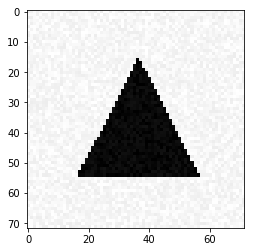

In [3]:
## Examples of generated data
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

In [4]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data...')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print('Done!')
    return [X, Y]

def generate_test_set_classification(free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, free_location)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data...')
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print('Done!')
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y, color='r'):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = color, linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)
    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

def generate_dataset_denoising(nb_samples, noise=20.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data...')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location, pair=True)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk(noise, free_location, pair=True)
        else:
            [X[i], V], [Y[i], W]  = generate_a_triangle(noise, free_location, pair=True)
    
    X = (X + noise) / (255 + 2 * noise)
    Y = Y / 255
    print('Done!')
    return [X, Y]

def generate_test_set_denoising(free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, 20, free_location)
    return [X_test, Y_test]

### Simple classification

We generate a training set of images of simple geometric shapes (rectangle, disk, triangle)
centered in the images :

In [5]:
[x_train, y_train] = generate_dataset_classification(300, 20)
y_train = to_categorical(y_train, num_classes=None)
x_rect = generate_a_rectangle()
x_rect = x_rect.reshape(1, x_rect.shape[0])
x_disk = generate_a_disk()
x_disk = x_disk.reshape(1, x_disk.shape[0])
x_tri, _ = generate_a_triangle()
x_tri = x_tri.reshape(1, x_tri.shape[0])
[x_test, y_test] = generate_test_set_classification()

Creating data...
Done!
Creating data...
Done!


We build and train a linear classifier in Keras to classify a image into one of the three possible categories

In [6]:
BATCH_SIZE = 32
INIT_LR = 0.0001
EPOCHS = 20
input_shape=(x_train.shape[1],)

In [7]:
model = Sequential()
# # Input - Layer
model.add(Dense(68, input_shape=input_shape, activation='sigmoid'))
# Output- Layer
model.add(Dense(3, activation='softmax'))

In [8]:
opt_sgd = SGD(lr=INIT_LR, decay=1e-6, momentum=0.9, nesterov=True)
opt_adam = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_sgd, model_adam = model, model
model_sgd.compile(loss="categorical_crossentropy", optimizer=opt_sgd, metrics=["accuracy"])
model_adam.compile(loss="categorical_crossentropy", optimizer=opt_adam, metrics=["accuracy"])

We then try using the stochastic gradient descent optimizer, eventually the Adam optimizer

In [9]:
model_sgd.fit(x_train, y_train, epochs= EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/20
300/300 [==============================] - 0s - loss: 1.0604 - acc: 0.4533     
Epoch 2/20
300/300 [==============================] - 0s - loss: 0.9577 - acc: 0.4767     
Epoch 3/20
300/300 [==============================] - 0s - loss: 0.8344 - acc: 0.6700     
Epoch 4/20
300/300 [==============================] - 0s - loss: 0.7647 - acc: 0.6600     
Epoch 5/20
300/300 [==============================] - 0s - loss: 0.7004 - acc: 0.7300     
Epoch 6/20
300/300 [==============================] - 0s - loss: 0.6101 - acc: 0.7800     
Epoch 7/20
300/300 [==============================] - 0s - loss: 0.5671 - acc: 0.8067     
Epoch 8/20
300/300 [==============================] - 0s - loss: 0.5288 - acc: 0.8600     
Epoch 9/20
300/300 [==============================] - 0s - loss: 0.5031 - acc: 0.8667     
Epoch 10/20
300/300 [==============================] - 0s - loss: 0.4620 - acc: 0.8367     
Epoch 11/20
300/300 [==============================] - 0s - loss: 0.4586 - acc: 0.8633   

In [10]:
model_sgd.evaluate(x_test, y_test)

 32/300 [==>...........................] - ETA: 0s

[0.3120204226175944, 0.9300000007947286]

In [11]:
print('Disk:', model_sgd.predict(x_disk), '\nRectangle:', model_sgd.predict(x_rect), '\nTriangle:', model_sgd.predict(x_tri))

Disk: [[0.10565389 0.82728463 0.06706155]] 
Rectangle: [[0.9249774  0.07394195 0.00108057]] 
Triangle: [[0.01117499 0.00145035 0.98737466]]


**Comment** : The model which is run with SGD achieves 93% accuracy on the test set and recognizes all the 3 categories of shapes

In [12]:
model_adam.fit(x_train, y_train, epochs= EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/20
300/300 [==============================] - 0s - loss: 0.2864 - acc: 0.9533     
Epoch 2/20
300/300 [==============================] - 0s - loss: 0.2703 - acc: 0.9767     
Epoch 3/20
300/300 [==============================] - 0s - loss: 0.2616 - acc: 0.9733     
Epoch 4/20
300/300 [==============================] - 0s - loss: 0.2460 - acc: 0.9533     
Epoch 5/20
300/300 [==============================] - 0s - loss: 0.2478 - acc: 0.9867     
Epoch 6/20
300/300 [==============================] - 0s - loss: 0.2388 - acc: 0.9633     
Epoch 7/20
300/300 [==============================] - 0s - loss: 0.2453 - acc: 0.9400     
Epoch 8/20
300/300 [==============================] - 0s - loss: 0.2332 - acc: 0.9833     
Epoch 9/20
300/300 [==============================] - 0s - loss: 0.2190 - acc: 0.9533     
Epoch 10/20
300/300 [==============================] - 0s - loss: 0.2199 - acc: 0.9733     
Epoch 11/20
300/300 [==============================] - 0s - loss: 0.2150 - acc: 0.9700   

In [13]:
model_adam.evaluate(x_test, y_test)

 32/300 [==>...........................] - ETA: 0s

[0.17709652801354725, 0.9866666666666667]

In [14]:
print('Disk:', model_adam.predict(x_disk), '\nRectangle:', model_adam.predict(x_rect), '\nTriangle:', model_adam.predict(x_tri))

Disk: [[0.03705197 0.9546134  0.0083346 ]] 
Rectangle: [[9.9295992e-01 6.4136297e-03 6.2641705e-04]] 
Triangle: [[0.00728653 0.00114388 0.9915696 ]]


**Comment** : The model which is run with ADAM achieves 99% accuracy on the test set and recognizes all the 3 categories of shapes

We note that both methods run very well on this problem and that ADAM does provide more accurate results with the chosen hyperparameters. 

### Visualization of the Solution

We now like to visualize the weights of the linear classifier, and visualize the 3 columns of the matrix of the classifier as images.

In [15]:
list_weights = model_adam.get_weights()
weights_classifier = list_weights[0]

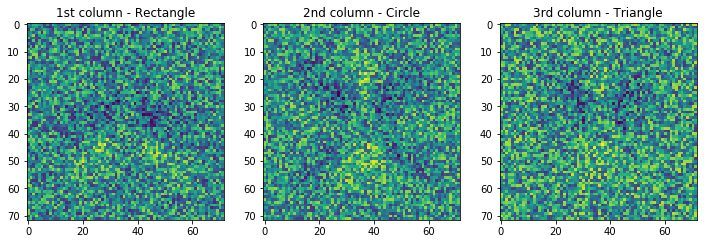

In [16]:
plt.figure(figsize=(12,12))

plt.subplot("131")
plt.imshow(weights_classifier[:,0].reshape(72,72))
plt.title("1st column - Rectangle")
plt.subplot("132")
plt.imshow(weights_classifier[:,1].reshape(72,72))
plt.title("2nd column - Circle")
plt.subplot("133")
plt.imshow(weights_classifier[:,2].reshape(72,72))
plt.title("3rd column - Triangle")
plt.show()

** Comment:** We can observe some interesting patterns according to the category we plot

### A More Diffcult Classification Problem

Now, the shapes are allowed to move within the images and change dimensions. We retrain the linear classiffer on this new training set.

In [17]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
[X_test, Y_test] = generate_test_set_classification(True)
Y_train = to_categorical(Y_train, num_classes=None)

Creating data...
Done!
Creating data...
Done!


In [18]:
model.compile(loss="categorical_crossentropy", optimizer=opt_adam, metrics=["accuracy"])
model.fit(X_train, Y_train, epochs= EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/20
300/300 [==============================] - 0s - loss: 1.4928 - acc: 0.3100     
Epoch 2/20
300/300 [==============================] - 0s - loss: 1.1201 - acc: 0.3533     
Epoch 3/20
300/300 [==============================] - 0s - loss: 1.1022 - acc: 0.3200     
Epoch 4/20
300/300 [==============================] - 0s - loss: 1.0904 - acc: 0.3733     
Epoch 5/20
300/300 [==============================] - 0s - loss: 1.0853 - acc: 0.3733     
Epoch 6/20
300/300 [==============================] - 0s - loss: 1.0550 - acc: 0.4533     
Epoch 7/20
300/300 [==============================] - 0s - loss: 1.0457 - acc: 0.4400     
Epoch 8/20
300/300 [==============================] - 0s - loss: 1.0387 - acc: 0.4933     
Epoch 9/20
300/300 [==============================] - 0s - loss: 1.0245 - acc: 0.4700     
Epoch 10/20
300/300 [==============================] - 0s - loss: 1.0135 - acc: 0.4800     
Epoch 11/20
300/300 [==============================] - 0s - loss: 1.0049 - acc: 0.5067   

In [19]:
model.evaluate(X_test, Y_test)

 32/300 [==>...........................] - ETA: 0s

[0.967630865573883, 0.5233333329359691]

**Comment** : The same model which achieved 99% accuracy on the test set now performs very poorly (52% accuracy on the test set) with the same hyperparameters and when trained on this new dataset.

We now train a convolutional deep network on this new dataset. 

In [20]:
conv_model = Sequential()
conv_model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(72, 72, 1)))
conv_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(3, activation='softmax'))

In [21]:
conv_model.compile(loss="categorical_crossentropy", optimizer=opt_adam, metrics=["accuracy"])

In [22]:
conv_model.fit(X_train.reshape(-1,72,72,1), Y_train, epochs= EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/20
300/300 [==============================] - 1s - loss: 1.2477 - acc: 0.3167     
Epoch 2/20
300/300 [==============================] - 0s - loss: 1.0864 - acc: 0.4400     
Epoch 3/20
300/300 [==============================] - 0s - loss: 0.9607 - acc: 0.6200     
Epoch 4/20
300/300 [==============================] - 0s - loss: 0.9044 - acc: 0.6933     
Epoch 5/20
300/300 [==============================] - 0s - loss: 0.8359 - acc: 0.7433     
Epoch 6/20
300/300 [==============================] - 0s - loss: 0.7951 - acc: 0.7400     
Epoch 7/20
300/300 [==============================] - 0s - loss: 0.7412 - acc: 0.7833     
Epoch 8/20
300/300 [==============================] - 0s - loss: 0.7193 - acc: 0.7933     
Epoch 9/20
300/300 [==============================] - 0s - loss: 0.6917 - acc: 0.7800     
Epoch 10/20
300/300 [==============================] - 0s - loss: 0.6615 - acc: 0.7867     
Epoch 11/20
300/300 [==============================] - 0s - loss: 0.6319 - acc: 0.7733   

In [23]:
conv_model.evaluate(X_test.reshape(-1,72,72,1), Y_test)

300/300 [==============================] - 0s     


[0.7148958373069764, 0.7233333333333334]

**Comment** : Using the **same hyperparameters and optimizers**, we achieve a superior of accuracy of close to 75%: using convnets is more appropriated to this classification problem as we can expect for image data. 

Note that a more sophisticated hyperparameter search can lead to higher accuracy results: **the point here is to show the significance of using convnets over fully connected architectures on more realistic images where shapes are allowed to move.**

### A Regression Problem

The task now is to predict the image locations of the vertices of a triangle, given an image of this
triangle.

We generate a training set and visualize a training sample:

Creating data...
Done!
Creating data...
Done!


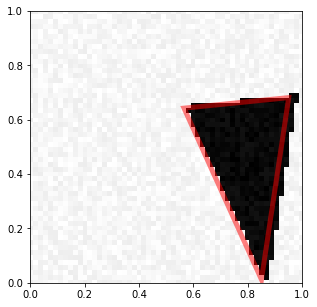

In [24]:
[X_train_reg, Y_train_reg] = generate_dataset_regression(300, 20)
[X_test_reg, Y_test_reg] = generate_test_set_regression()
visualize_prediction(X_train_reg[0], Y_train_reg[0])

In [25]:
BATCH_SIZE = 32
INIT_LR = 0.0001
EPOCHS = 50
input_shape=(X_train_reg.shape[1],)

def vertice_sorting(Y):
    n = Y.shape[0]
    for i in range(n):
        U = Y[i][::2]
        V = Y[i][1::2]
        idx = np.argsort(U)
        U = U[idx]
        V = V[idx]
        Y[i] = [U[0], V[0], U[1], V[1], U[2], V[2]]
    return Y
     
X_train_reg = X_train_reg.reshape((-1, 72,72,1))
X_test_reg = X_test_reg.reshape((-1, 72,72,1))
Y_train_reg = vertice_sorting(Y_train_reg)
Y_test_reg = vertice_sorting(Y_test_reg)

In [26]:
model_reg = Sequential()
# # Input - Layer
model_reg.add(Conv2D(64, (3, 3), activation='relu', input_shape=(72,72,1)))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_reg.add(Conv2D(32, (3,3), activation='relu'))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_reg.add(Conv2D(16, (3,3), activation='relu'))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_reg.add(Flatten())
# Output- Layer
model_reg.add(Dense(6))

In [27]:
opt_adam = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_reg.compile(loss="mean_squared_error", optimizer=opt_adam)

In [28]:
model_reg.fit(X_train_reg, Y_train_reg, epochs= EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/50
300/300 [==============================] - 3s - loss: 0.2568     
Epoch 2/50
300/300 [==============================] - 3s - loss: 0.1756     
Epoch 3/50
300/300 [==============================] - 3s - loss: 0.0995     
Epoch 4/50
300/300 [==============================] - 3s - loss: 0.0693     
Epoch 5/50
300/300 [==============================] - 3s - loss: 0.0634     
Epoch 6/50
300/300 [==============================] - 3s - loss: 0.0604     
Epoch 7/50
300/300 [==============================] - 3s - loss: 0.0589     
Epoch 8/50
300/300 [==============================] - 3s - loss: 0.0577     
Epoch 9/50
300/300 [==============================] - 3s - loss: 0.0563     
Epoch 10/50
300/300 [==============================] - 3s - loss: 0.0553     
Epoch 11/50
300/300 [==============================] - 3s - loss: 0.0538     
Epoch 12/50
300/300 [==============================] - 3s - loss: 0.0521     
Epoch 13/50
300/300 [==============================] - 3s - loss: 0.0504 

In [29]:
Y_train_reg_pred = model_reg.predict(X_train_reg)
Y_test_reg_pred = model_reg.predict(X_test_reg)

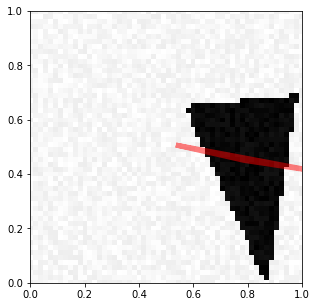

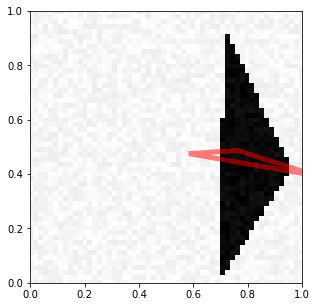

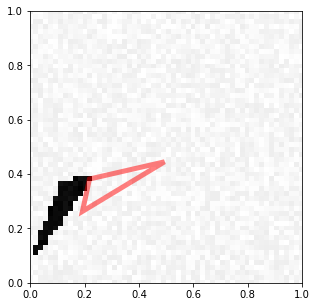

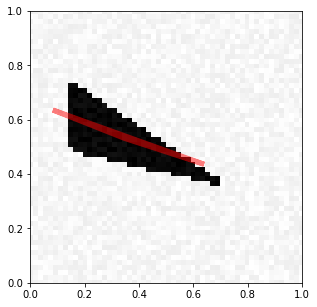

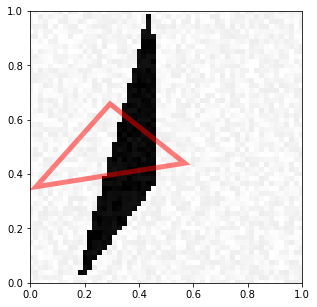

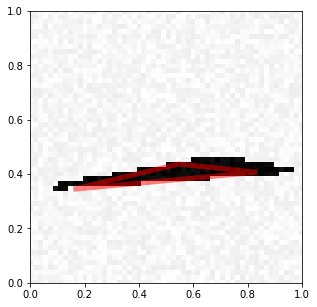

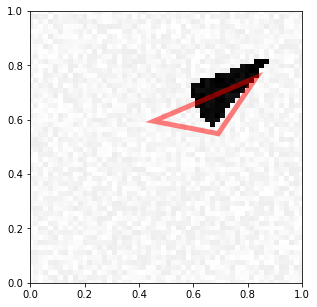

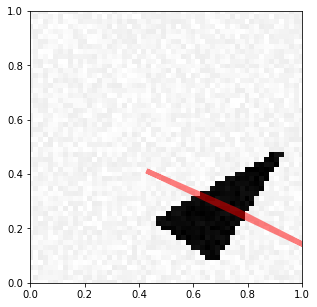

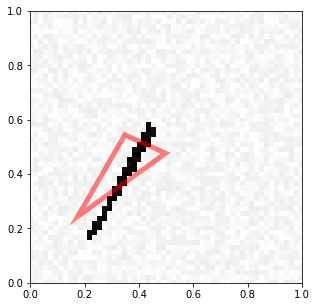

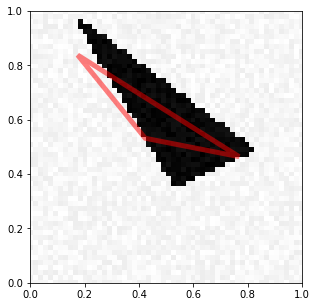

In [30]:
## Training set
for i in range(10):
    visualize_prediction(X_train_reg[i], Y_train_reg_pred[i])

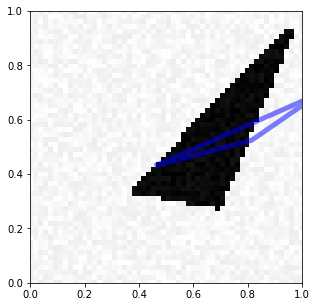

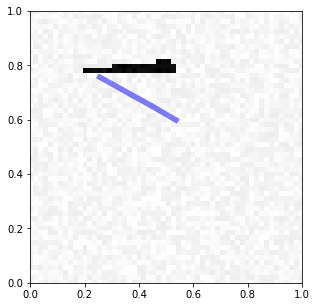

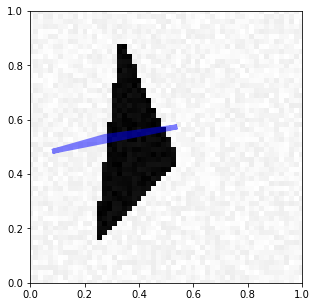

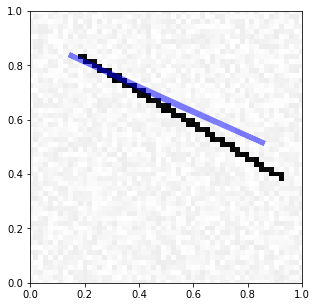

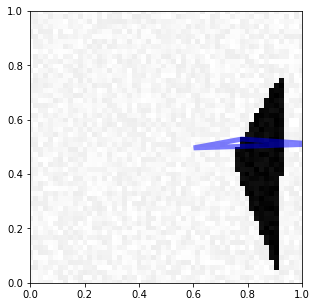

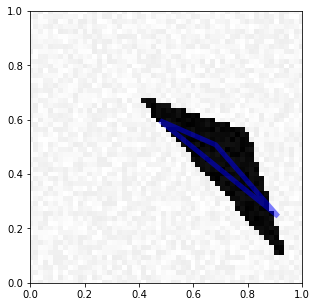

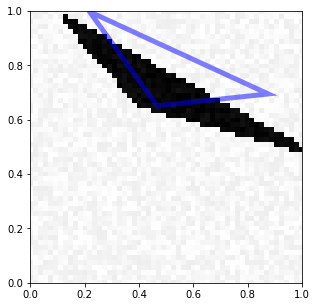

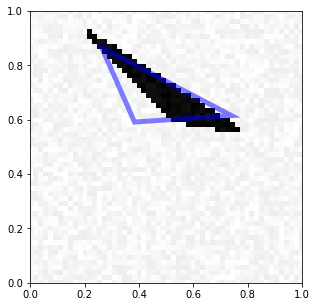

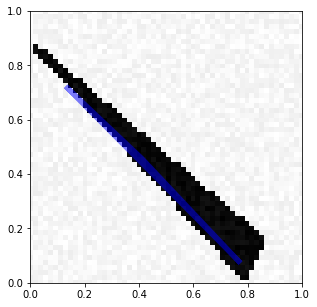

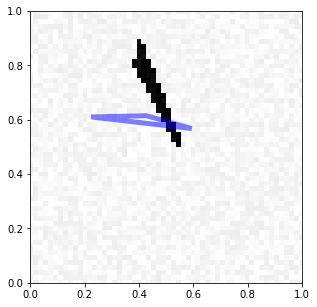

In [31]:
## Test set
for i in range(10):
    visualize_prediction(X_test_reg[i], Y_test_reg_pred[i], color='b')

**Comment** : We achieve satisfactory regression results over the training and testing sets, with however few disappoiting results. 

### Hourglass network

We implement a hourglass network for denoising: we modified the generate_a_* functions to generate
pairs of images, where one image has noise with random amplitude, and the second image has the
same content but without the noise. We then train the network to predict a noise-free image given a noisy
image as input.

In [32]:
[X_train_den, Y_train_den] = generate_dataset_denoising(300)
X_train_den = X_train_den.reshape((-1, 72,72,1))
Y_train_den = Y_train_den.reshape((-1, 72,72,1))
[X_test_den, Y_test_den] = generate_test_set_denoising()
X_test_den = X_test_den.reshape((-1, 72,72,1))
Y_test_den = Y_test_den.reshape((-1, 72,72,1))

Creating data...
Done!
Creating data...
Done!


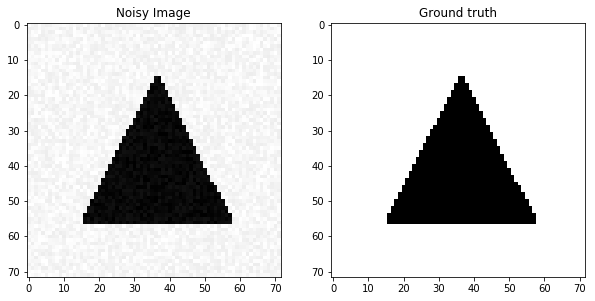

In [33]:
idx = np.random.randint(50)
plt.figure(figsize=(10,7))
plt.subplot("121")
plt.title("Noisy Image")
plt.imshow(X_train_den[idx].reshape(72,72), cmap='gray')
plt.subplot("122")
plt.title("Ground truth")
plt.imshow(Y_train_den[idx].reshape(72,72), cmap='gray')
plt.show()

In [ ]:
hourglass = Sequential()
hourglass.add(Conv2D(8, (3,3), activation='relu', input_shape=(72,72,1), padding='same'))
hourglass.add(MaxPooling2D())
hourglass.add(Conv2D(8, (3,3), activation='relu', padding='same'))
hourglass.add(MaxPooling2D())
hourglass.add(Conv2D(8, (3,3), activation='relu', padding='same'))
hourglass.add(MaxPooling2D())
hourglass.add(Conv2DTranspose(8, (3,3), activation='relu', padding='same'))
hourglass.add(UpSampling2D())
hourglass.add(Conv2DTranspose(8, (3,3), activation='relu', padding='same'))
hourglass.add(UpSampling2D())
hourglass.add(Conv2DTranspose(1, (3,3), activation='relu', padding='same'))
hourglass.add(UpSampling2D())
hourglass.add(Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same'))

hourglass.compile(optimizer='adagrad', loss='binary_crossentropy')
hourglass.fit(X_train_den, Y_train_den, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/50


We now plot the reconstruction

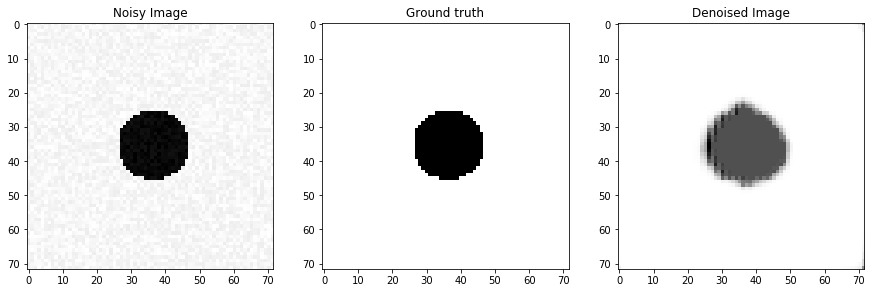

In [48]:
idx = np.random.randint(50)
plt.figure(figsize=(15,7))
plt.subplot("131")
plt.title("Noisy Image")
plt.imshow(X_test_den[idx].reshape(72,72), cmap='gray')
plt.subplot("132")
plt.title("Ground truth")
plt.imshow(Y_test_den[idx].reshape(72,72), cmap='gray')
plt.subplot("133")
plt.title('Denoised Image')
plt.imshow(hourglass.predict(X_test_den[[idx]]).reshape(72,72), cmap='gray')
plt.show()

**Comment** We have trained a network to predict a noise-free image given a noisy image as input.